# **Finance and Risk Hackaton for Kin Analytics** 
## Esteban Braganza

Kin Security is a security service company that offers a variety of products to its clients. In
specific, their star product, “Kin Safety”, has been in the market since 2012 and has been
a total success in the European Market. 

For this product, a client must sign a contract,
pay the installation costs, and a monthly fee for the service. However, in recent years, Kin
Security has seen that a lot of its clients have canceled “Kin Safety” before two years. 

The
biggest problem with this phenomenon is that “Kin Safety” has a significant fixed cost.
80% of this cost is assumed by Kin Security in order to be able to match the prices of its
competition. Therefore, if a client leaves before two years, the company is not able to
recover their investment.

Thus, Kin Security has contacted you to help them develop a classification model that
allows them to predict if a client will stay less than two years with the product. With this
model, they plan to construct commercial campaigns that benefit those clients that will
stay more than two years and penalize the ones who will not.


Kin Security has recently bought information from a credit bureau because they think that
this information will be valuable to build the classification model. Specifically, they asked
for each client’s credit score 6 months before and 6 months after he/she purchased “Kin
Safety”. 

Additionally, Kin Security asked the client for all the transactions in their bank
account. For this project, we will assume that each client has only one bank account.
Also, most of the clients that apply for “Kin Safety” usually have another product from Kin
Security.

1. **Objective:**
- Develop a two-year churn predictive model.

2. **Desired Population:**
- Contracts from 2015 onwards.
- Operations in Italy were closed this year (2019).
- Take out clients with more than 75% of their info missing.
- Each client should only have one contract in the database, no more.
- Remember that for a client to be eligible, it must have at least two years of
information within the company (even if it canceled the product).

## **Importación de Librerías**

In [1]:
## Importamos librerías

import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

import numpy as np
import pandas as pd
import pickle
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
#from pandas_profiling.utils.cache import cache_file

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Librerias de modelado
from sklearn import model_selection as ms
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from sklearn import tree


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Algunas funciones útiles**

In [3]:
### Algunas Funciones utiles

#Set others (para variables con muchas clases minoritarias)
def set_others(df, column, num_values):
    """
    Esta funcion ayuda cuando tenemos variables categoricas con muchas categorias pero en donde los datos
    se distribuyen mayoritariamente en unas cuantas, de esta forma se pueden agrupar en una categoria others aquellas que tienen pocos casos.
    """
    top_categories = df[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    return pd.Categorical(df[column], categories=top_categories_list).fillna('Others')

# Plot Categories
def plot_categories(df, column, target,target_categoric=True):
    
    """Dibuja el numero de casos que tiene una categoria y tambien un boxplot con el target en caso de que el
    target es numerico. Si el target es categorico dibuja un grafico en el que vemos 
    cuanto discriminan las categorias"""
    if target_categoric== False:

      # Plot1
        
        plt.figure(figsize=(15,8))
        plt.subplot(2,1,1)
        '''
        splot=sns.countplot(df[column])

        for p in splot.patches:
          splot.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        size=15,
                        xytext = (0, -12), 
                        textcoords = 'offset points')
        '''
        #Plot 2
        
        #plt.subplot(2,1,2)
        splot2=sns.boxplot(
        data = df, 
        x = column,
        y = target)
        for p in splot2.patches:
          splot2.annotate(format(100*p.get_height()/df.shape[0], '.2f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
        plt.xticks(rotation=45)

        # Show
        plt.show()


    else:
      
        plt.figure(figsize=(30,10))

        # Plot 1
        
        plt.subplot(2,1,1)
        splot=sns.countplot(df[column])
        for p in splot.patches:
          splot.annotate(format(100*p.get_height()/df.shape[0], '.2f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
          
        plt.xticks(rotation=45)

        # Plot 2

        plt.subplot(2,1,2)
        splot2=sns.countplot(x=column,hue=target, 
                    data=df)
        for p in splot2.patches:
          splot2.annotate(format(100*p.get_height()/df.shape[0], '.2f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

        # Show      
        plt.show()

# Tipos de variables
def obtener_lista_variables(dataset,target):
    
    '''Nos ayuda a separar entre variables categoricas booleanas y numericas'''
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype=="float64" or dataset[i].dtype=="int64") and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype=="float64" or dataset[i].dtype=="int64" or dataset[i].dtype=="int8" or dataset[i].dtype=="int32") and len(dataset[i].unique())== 2  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype=="object" or dataset[i].dtype.name == 'category')  and i not in target:
              lista_categoricas.append(i)
                
    return lista_numericas, lista_boolean, lista_categoricas

# One Hot encoder function
def OneHotEncoderFunction(df, column_name):
    """Obtains a new data frame with the one hot encoding of the selected variable """
    _dummy_dataset = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, _dummy_dataset], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

# Simple report
def generate_simple_report(data_frame):

  """ Esta función imprime un reporte de la base de datos rápido"""
  
  print('-- Un vistazo Rapido --')
  print(data_frame.head(10))
  print()
  print('-- Informacion de las Variables --')
  print(data_frame.info())
  print()
  print('-- Descripcion de las Variables --')
  print(data_frame.describe())
  print()
  print('--Nulos dentro del Data Set --')
  print(pd.DataFrame(data_frame.isnull().sum(), columns =['NULOS']).reset_index().sort_values(by ='NULOS', ascending = True))
  print()
  print('--Valores Duplicados--')
  print('Duplicados: ',data_frame.duplicated().sum())
  print()
  print('--Valores Unicos--')
  print(pd.DataFrame(data_frame.nunique(),columns=['unique_values']).reset_index().sort_values('unique_values',ascending=False))
  

## **Importación de Bases de Datos**

In [15]:
# Open data bases
clients = pd.read_csv('/content/drive/MyDrive/Hackathon-Finance and Risk/BASE DE DATOS/clients_table.txt')
credit_scores = pd.read_csv('/content/drive/MyDrive/Hackathon-Finance and Risk/BASE DE DATOS/credit_score_table.txt')
products = pd.read_csv('/content/drive/MyDrive/Hackathon-Finance and Risk/BASE DE DATOS/products_table.txt')
transactions = pd.read_csv('/content/drive/MyDrive/Hackathon-Finance and Risk/BASE DE DATOS/transactions_table.txt')

In [5]:
# Simple reports
generate_simple_report(clients)

-- Un vistazo Rapido --
   CustomerId    Surname Geography  ... application_date   exit_date  birth_date
0    15745584      EIRLS   Germany  ...       2018-12-14         NaN  1997-09-18
1    14990118     MOLOCK     Italy  ...       2019-01-08         NaN  1980-08-03
2    14733224    PAWLUCH     Italy  ...       2012-08-01  2013-08-09  1977-08-19
3    14648573      NALLS     Spain  ...       2019-06-19         NaN  1979-02-27
4    15365443     EBERLE     Italy  ...       2014-01-26  2015-12-04  1972-12-21
5    15638124   BRASHERS     Italy  ...       2018-02-23         NaN  1983-01-13
6    14700520  TALLARICO     Italy  ...       2013-04-16  2013-08-02  1974-02-10
7    14523468   LASKOSKI     Spain  ...       2017-12-28  2018-11-19  1972-10-30
8    15885904      OEDER     Italy  ...       2014-06-12  2016-10-09  1984-04-22
9    14746757  MARTINSON     Italy  ...       2013-09-01  2014-09-18  1972-02-06

[10 rows x 10 columns]

-- Informacion de las Variables --
<class 'pandas.core.frame

In [6]:
# Credit Scores Table
generate_simple_report(credit_scores)

-- Un vistazo Rapido --
   CustomerId     Date  Score
0    14759722  2018-07    717
1    15907276  2011-09    562
2    15346641  2013-01    604
3    15595126  2018-08    469
4    15227788  2013-09    655
5    15967291  2012-08    496
6    14558133  2017-12    546
7    14588147  2012-04    706
8    15872824  2013-03    567
9    15270074  2014-07    634

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500000 entries, 0 to 19499999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CustomerId  int64 
 1   Date        object
 2   Score       int64 
dtypes: int64(2), object(1)
memory usage: 446.3+ MB
None

-- Descripcion de las Variables --
         CustomerId         Score
count  1.950000e+07  1.950000e+07
mean   1.525000e+07  6.496909e+02
std    4.330127e+05  9.661629e+01
min    1.450000e+07  1.610000e+02
25%    1.487500e+07  5.850000e+02
50%    1.525000e+07  6.500000e+02
75%    1.562500e+07  7.150000e+02
max    1.60

In [7]:
# Products table
generate_simple_report(products)

-- Un vistazo Rapido --
                  ContractId  CustomerId   Products
0  5Xo9sCduOGo5EhBYhzKrSlLIA    14993808  Product B
1  3nQbqbnpTeSkYIJWT1UDe1GZ1    15560417  Product B
2  PD9KwDPOwyJWO6LJKPGBbkrCz    15406428  Product C
3  IhS7pz8lu07LCZSqYNlL0fuLP    15604313  Product B
4  ftUey4oVmkZj8RaBVFH6SNzVM    14952409  Product C
5  fKxPx2Lxrbe2w9RwrtacgFqh8    15780847  Product B
6  I1l0Q0fG1fqvCxyHmooOMiz1Q    15943948  Product B
7  sCvynJ3tQekspLIdOMQM2Xv7S    14646170  Product D
8  HD0zcsAUzBwjJiHOJP4xGHeJg    14572090  Product A
9  gPrEgae03EvrWZbTyVWCjilHp    15716166  Product B

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739192 entries, 0 to 3739191
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   ContractId  object
 1   CustomerId  int64 
 2   Products    object
dtypes: int64(1), object(2)
memory usage: 85.6+ MB
None

-- Descripcion de las Variables --
         CustomerId
count  3.739192e+06
mean

In [8]:
# Transactions Table
generate_simple_report(transactions)

-- Un vistazo Rapido --
   CustomerId Transaction     Value
0    15653320     trans_4   -294.03
1    14955663     trans_3   1297.97
2    15218505     trans_4    191.28
3    15391934     trans_3   2299.07
4    14847291     trans_3   1612.10
5    14682542     trans_2   -324.99
6    15635388     trans_4    403.94
7    15119128     trans_5  43630.95
8    15457173     trans_2   -884.89
9    14853007     trans_5  34630.94

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500000 entries, 0 to 7499999
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   CustomerId   int64  
 1   Transaction  object 
 2   Value        float64
dtypes: float64(1), int64(1), object(1)
memory usage: 171.7+ MB
None

-- Descripcion de las Variables --
         CustomerId         Value
count  7.500000e+06  7.500000e+06
mean   1.525000e+07  1.594311e+04
std    4.330127e+05  3.907205e+04
min    1.450000e+07 -8.426570e+03
25%    1.487500e+07 -2.6511

## **Desired Population**

- Contracts from 2015 onwards.
- Operations in Italy were closed this year (2019).
- Take out clients with more than 75% of their info missing.
- Each client should only have one contract in the database, no more.
- Remember that for a client to be eligible, it must have at least two years of
information within the company (even if it canceled the product).

For this purpose a function is designed to assign the filters needed to obtain the desired population. We have many purposes for the data set. The first one is to know wihch are the clients that we are focusing our efforts. And to have data ready for modelling the 2 year churn probability. We need to know the clients who are less likely to drop so we can focus on them. 

**Decisions taken:**

- Clients with application date from 2015 onwards
- We eliminate Italy clients as they are not clients anymore.
- Drop duplicates
- Eliminate clients with 7 or more of 9 relevant information variables with nulls (75%)
- we finally filter clients with at least 2 years of information so clients
who bought the product untill 2017-11-30
- Target variable is a client that drops before 2 years of antiquity

In [11]:
# First look to the data
clients.head()

,CustomerId,Surname,Geography,Gender,HasCrCard,IsActiveMember,EstimatedSalary,application_date,exit_date,birth_date
0,15745584,EIRLS,Germany,Female,0.0,1.0,0.00,2018-12-14,NaN,1997-09-18
1,14990118,MOLOCK,Italy,Male,1.0,0.0,121219.28,2019-01-08,NaN,1980-08-03
2,14733224,PAWLUCH,Italy,Female,1.0,1.0,159663.59,2012-08-01,2013-08-09,1977-08-19
3,14648573,NALLS,Spain,Male,1.0,0.0,140827.98,2019-06-19,NaN,1979-02-27
4,15365443,EBERLE,Italy,Male,1.0,0.0,35521.28,2014-01-26,2015-12-04,1972-12-21


In [41]:
# Obtain Desired population function

def desired_pop(data):

  '''The following function applies the desired population filters and obtains the number of
  rows after each filter'''

  print('--Inital number of records--')
  print(data.shape[0])
  print()

  # 1st filter contracts from 2015.

  # We also prepare birth date and obtain the maximum date available

  data['birth_date'] = pd.to_datetime(data['birth_date'], format = '%Y-%m-%d')
  data['application_date'] = pd.to_datetime(data['application_date'], format = '%Y-%m-%d')

  max_date = data['application_date'].max()
  desired_data = data[data['application_date'].dt.year >= 2015]
  print('--1st filter number of records erased clients with contracts before 2015--')
  print(desired_data.shape[0])
  print()

  
  
  # 2nd filter erased Italy clients as they are no longer part of the company so estimating their churn probability is useless.
  
  italy_data_2019 = desired_data[(desired_data['Geography']=='Italy')].index
  idx=list(italy_data_2019)
  desired_data = desired_data.drop(idx)
  print('--2nd filter number of records erased Italy clients as they no longer are part of the company--')
  print(desired_data.shape[0])
  print()
  
  # 3rd filter clients with 75% of information missing

  idx2 = desired_data.index
  n_vars = (desired_data.shape[1] - 1) # -1 no tomo en cuenta la variable CustomerId
  desired_data['percentage_nulls'] = desired_data.isna().sum(axis = 1)/ n_vars
  desired_data.drop(desired_data[desired_data.percentage_nulls >= 0.75].index, inplace=True)
  print('--3rd filter number of records erased clients with 75% of information missing--')
  print(desired_data.shape[0])
  print()

  # 4th filter we need unique clients

  if desired_data.duplicated().sum() > 0:
    print('Number of Duplicates:')
    print(desired_data.duplicated().sum())
    
    # Drop
    desired_data.drop_duplicates(inplace=True)
    
    # Report
    print()
    print('Duplicates erased')
    print()
    print('New number of duplicates:')
    print(desired_data.duplicated().sum())
    print()

  # We need to have the same number of Customers Id as number of rows.
  
  if len(desired_data.CustomerId) == desired_data.shape[0]:
    print('Filter Succesful')
    print()
  print('--4th filter number of records erased duplicated observations--')
  print(desired_data.shape[0])
  print()

  # 5th filter Clients with at least 2 years history for being elegible for the campaing we do not filter here just obtain antiquity.

  print()
  print('--Latest date in Data Frame is--')
  print(max_date)
  print()

  # Some useful time variables for age variable and target variable

  desired_data['last_date'] = np.where(desired_data['exit_date'].isnull()==True, max_date, desired_data['exit_date'])
  desired_data['antiquity'] = (desired_data['last_date'] - desired_data['application_date']).dt.days / 365
  desired_data['age'] = ((desired_data['application_date'] - desired_data['birth_date']).dt.days / 365).astype('int')

  #Filter for desired population

  desired_data = desired_data[desired_data['application_date'] < '2017-12-01']
  #desired_data = desired_data[desired_data['application_date'].dt.year < 2018]

  print('--5th filter Clients with at least 2 years history so clients who entered until november 2017--')
  print(desired_data.shape[0])
  print()

  # Last database process: Generate target variable

  print('-- Clients that left the company before 2 years of antiquity --')
  desired_data['target'] = (desired_data['antiquity'] < 2) & (desired_data['exit_date'].isnull() == False)
  print('-- Target variable created --')

  # Drop useles data
  desired_data = desired_data.reset_index(drop=True)
  desired_data.drop(columns=['Surname','exit_date'], inplace=True)

  return desired_data
  

clients_clean = desired_pop(clients)



--Inital number of records--
1545000

--1st filter number of records erased clients with contracts before 2015--
623242

--2nd filter number of records erased Italy clients as they no longer are part of the company--
487424

--3rd filter number of records erased clients with 75% of information missing--
464075

Number of Duplicates:
13513

Duplicates erased

New number of duplicates:
0

Filter Succesful

--4th filter number of records erased duplicated observations--
450562


--Latest date in Data Frame is--
2019-11-30 00:00:00

--5th filter Clients with at least 2 years history so clients who entered until november 2017--
10000

-- Clients that left the company before 2 years of antiquity --
-- Target variable created --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


In [18]:
## Class that create the rest of the relevant variables

class Feature_generator:

  ''' Class that modifies the clients data base obtaining new features from the rest of the databases'''

  def __init__(self, clients):
    self.clients = clients

  def obtain_age(self):
    ''' Obtain clients age at moment of application'''
    self.clients['birth_date'] = pd.to_datetime(self.clients['birth_date'], format = '%Y-%m-%d')
    self.clients['age'] = ((self.clients['application_date'] - self.clients['birth_date']).dt.days / 365).astype('int')
    
  def obtain_num_products(self, products):
    prod_df = products[['CustomerId', 'Products']].groupby(by='CustomerId').count().reset_index()
    self.clients = self.clients.merge(prod_df, how='left', on='CustomerId')
  
  def obtain_account_balance(self,transactions):
    balance = transactions[['CustomerId','Value']].groupby('CustomerId').sum().reset_index()
    balance.columns =['CustomerId','account_balance']
    balance.account_balance = round(balance.account_balance,2)
    self.clients = self.clients.merge(balance, how='left', on='CustomerId')

  def obtain_credit_score(self,credit_score):
    self.clients['Date'] = self.clients['application_date'].dt.to_period('M')
    self.clients['Date'] = self.clients['Date'].astype('str')
    self.clients = self.clients.merge(credit_score, how ='left', on = ['CustomerId', 'Date'])
    self.clients.drop(columns=['Date'], inplace=True)

  def obtain_date_features(self):
    self.clients['month'] = self.clients['application_date'].dt.month
    self.clients['dayofweek'] = self.clients['application_date'].dt.weekday
    self.clients['year'] = self.clients['application_date'].dt.year

  def drop_variables(self):
    self.clients.drop(columns=['percentage_nulls'],inplace = True)

# Features Generator process

generator = Feature_generator(clients=clients_clean)

# Generator Steps
generator.obtain_num_products(products) # 2
generator.obtain_account_balance(transactions) # 3
generator.obtain_credit_score(credit_scores) # 4
generator.obtain_date_features() # 5
generator.drop_variables() # 6

clients_clean = generator.clients

clients_clean.head()

,CustomerId,Geography,Gender,HasCrCard,IsActiveMember,EstimatedSalary,application_date,birth_date,last_date,antiquity,age,target,Products,account_balance,Score,month,dayofweek,year
0,15610711,Germany,Female,0.0,0.0,167673.37,2017-03-05,1976-10-21,2019-11-27,2.731507,40,False,1,128644.46,678,3,6,2017
1,15764170,Germany,Male,1.0,0.0,36579.53,2017-02-05,1972-04-02,2018-10-11,1.679452,44,True,1,93960.35,647,2,6,2017
2,15594720,Germany,Female,1.0,1.0,189339.60,2017-11-08,1982-05-14,2019-11-30,2.060274,35,False,2,102742.91,460,11,2,2017
3,15706552,France,Male,0.0,1.0,156731.91,2016-02-15,1979-09-09,2019-10-02,3.630137,36,False,1,85311.70,533,2,0,2016
4,15785358,Germany,Male,1.0,1.0,79366.98,2016-09-17,1969-11-11,2016-12-20,0.257534,46,True,1,106968.96,586,9,5,2016


## **EDA and Preprocesing**


The objective of this section is to asses wether the independent variables have some predictive power to discriminate between the target label. For this we will analize distributions, scatter plots and count plots to see which variables separate the best the our data. With more time I would have performed a different approach using the weight of evidence and informatino value but due to time constraints I would keep the analysis simple. 

In [19]:
# Quick look at the Data Base
generate_simple_report(clients_clean)

-- Un vistazo Rapido --
   CustomerId Geography  Gender  HasCrCard  ...  Score  month dayofweek  year
0    15610711   Germany  Female        0.0  ...    678      3         6  2017
1    15764170   Germany    Male        1.0  ...    647      2         6  2017
2    15594720   Germany  Female        1.0  ...    460     11         2  2017
3    15706552    France    Male        0.0  ...    533      2         0  2016
4    15785358   Germany    Male        1.0  ...    586      9         5  2016
5    15594084    France    Male        1.0  ...    524      3         3  2016
6    15756871     Spain    Male        1.0  ...    512      5         2  2015
7    15713655    France  Female        1.0  ...    720      6         1  2015
8    15632793    France  Female        1.0  ...    638      1         6  2017
9    15588341     Spain    Male        0.0  ...    647      5         4  2015

[10 rows x 18 columns]

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 en

## **Descriptive Analysis of the Created Variables**

After aplying all the filters we have obtained a tiny Data Set of exactly 10000 clients that meet the desired population requirements. We have used the rest of the data sets to create new variables and now we will analyze and preprocess the remaining data set for modelling.

In [20]:
# Describe new variables
new_variables = ['EstimatedSalary','age','account_balance','Score', 'Products']
df_describe = clients_clean[new_variables]
display(df_describe.describe())

,EstimatedSalary,age,account_balance,Score,Products
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,100090.239881,38.922000,76485.889288,650.528800,1.530200
std,57510.492818,10.488523,62397.405202,96.653299,0.581654
min,11.580000,18.000000,-0.000000,350.000000,1.000000
25%,51002.110000,32.000000,0.000000,584.000000,1.000000
50%,100193.915000,37.000000,97198.540000,652.000000,1.000000
75%,149388.247500,44.000000,127644.240000,718.000000,2.000000
max,199992.480000,92.000000,250898.090000,850.000000,4.000000


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


- There is a presence of an inbalanced data set with only 20% cases true, some rebalancing methods might be consider for modelling.

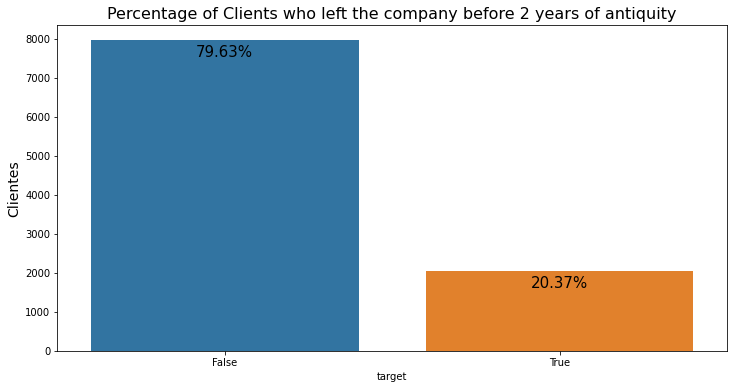

In [21]:
## Target Variable Analysis

plt.figure(figsize=(12,6))

p3 = sns.countplot(data=clients_clean, x = 'target')

for p in p3.patches:
  p3.annotate(format(100*p.get_height()/clients_clean.shape[0], '.2f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Clientes", size = 14)
plt.title('Percentage of Clients who left the company before 2 years of antiquity', size=16)

plt.show()


- The distribution of the estimated salary is not normal but appears to be a uniform distribution having equally number of cases in the different ranges of salaries. It does not seem to discriminate the target variable.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

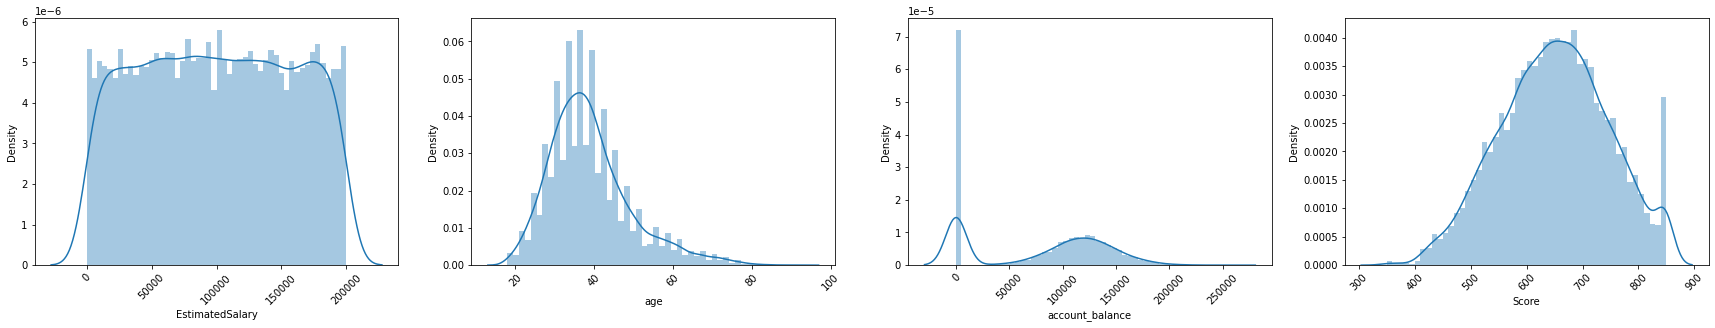

In [22]:
# Distributions of new created Variables

plt.figure(figsize=(30,10))

# Dist sin modificacion
plt.subplot(2,4,1)
sns.distplot(clients_clean['EstimatedSalary'], bins=50)
plt.xticks(rotation=45)

#Dist sin outliers
plt.subplot(2,4,2)
sns.distplot(clients_clean['age'],bins=50)
plt.xticks(rotation=45)

#Dist log de variable
plt.subplot(2,4,3)
sns.distplot(clients_clean['account_balance'],bins=50)
plt.xticks(rotation=45)

#Dist quantile scaled variable
plt.subplot(2,4,4)
sns.distplot(clients_clean['Score'],bins=50)
plt.xticks(rotation=45)


plt.show()



<Figure size 2160x720 with 0 Axes>

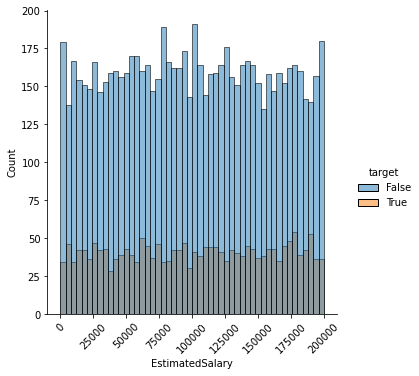

<Figure size 2160x720 with 0 Axes>

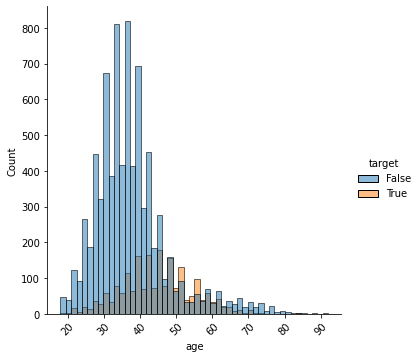

<Figure size 2160x720 with 0 Axes>

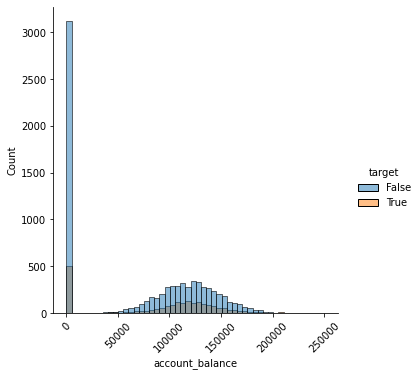

<Figure size 2160x720 with 0 Axes>

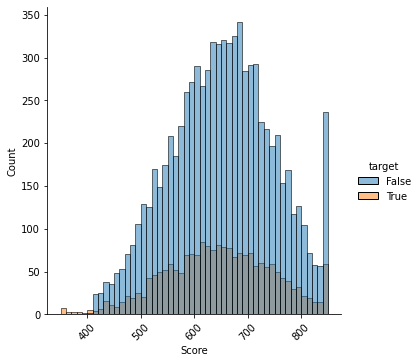

In [23]:
# Plots by target

variables = ['EstimatedSalary','age','account_balance','Score']

# Dist sin modificacion

for var in variables:

  plt.figure(figsize=(30,10))
  sns.displot(data = clients_clean, x =var,bins = 50, hue = 'target')
  plt.xticks(rotation=45)
  plt.show()

- The variable age seems to separate data in a more efficient way it cn be seen that clients in the range of 45 - 65 years old seem to leave the company more than others.

- Another variable that seems to discriminate better is the credit score which shows that clients with low credit scores tend to leave the company more often, however this effect is shown in clients with credic scores lower than 450.


<Figure size 2880x720 with 0 Axes>

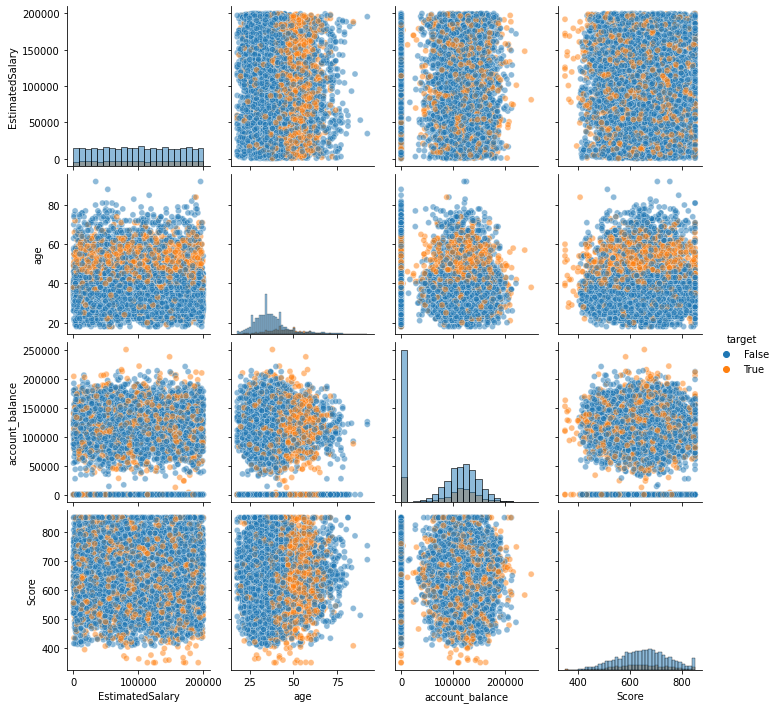

In [24]:
# Pair Plot with numerical Variables 

plt.figure(figsize=(40,10))

vars_ = ['EstimatedSalary', 'age', 'account_balance', 'Score']

sample = clients_clean.sample(frac=0.9)

g= sns.pairplot(sample,hue = 'target', diag_kind= 'hist',
             vars=vars_,
             plot_kws=dict(alpha=0.5), 
             diag_kws=dict(alpha=0.5))
plt.show()

- We can see some differences in client behaviour among countries. France has the highest difference between clients who leave and those who does not.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


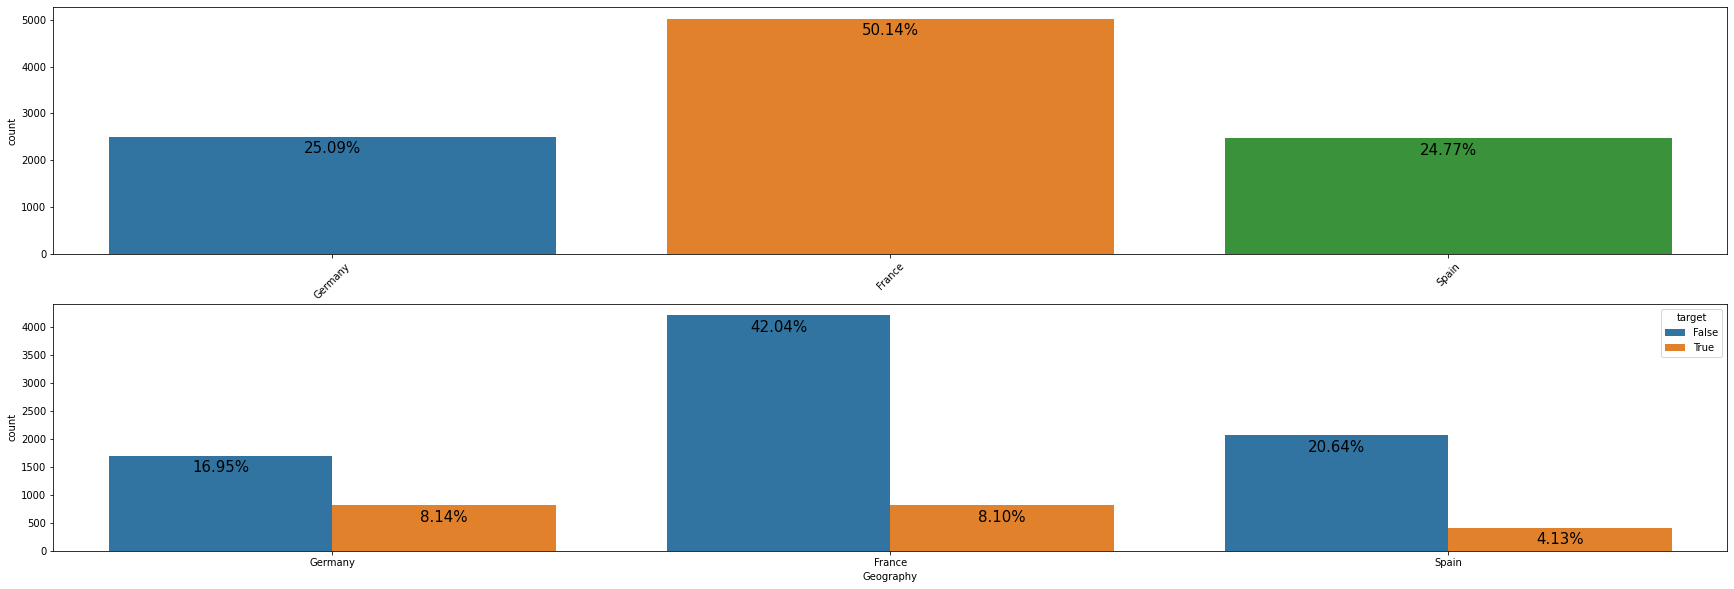

In [25]:
# Geography variable
plot_categories(clients_clean, column ='Geography', target='target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


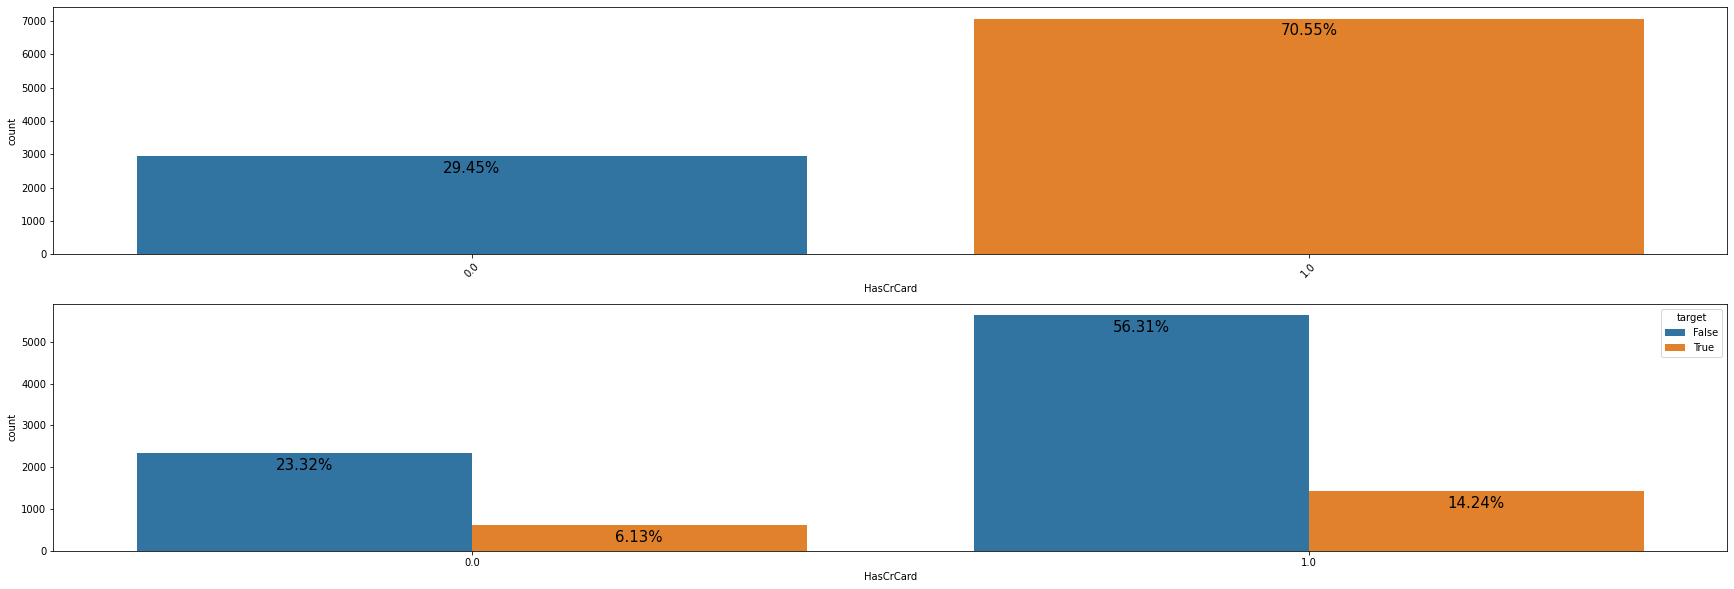

In [26]:
# Has card variable
plot_categories(clients_clean, column ='HasCrCard', target='target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


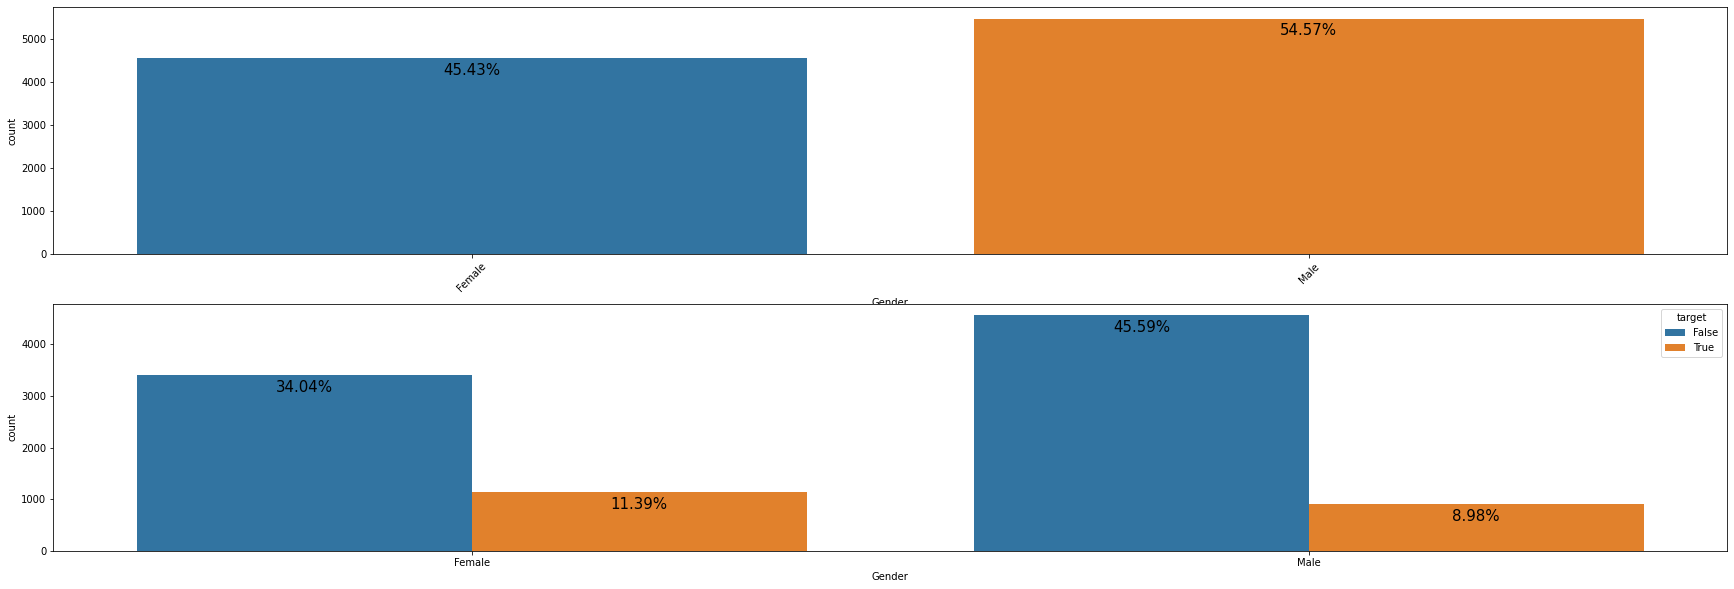

In [27]:
# Gender Variable

plot_categories(clients_clean, column ='Gender', target='target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


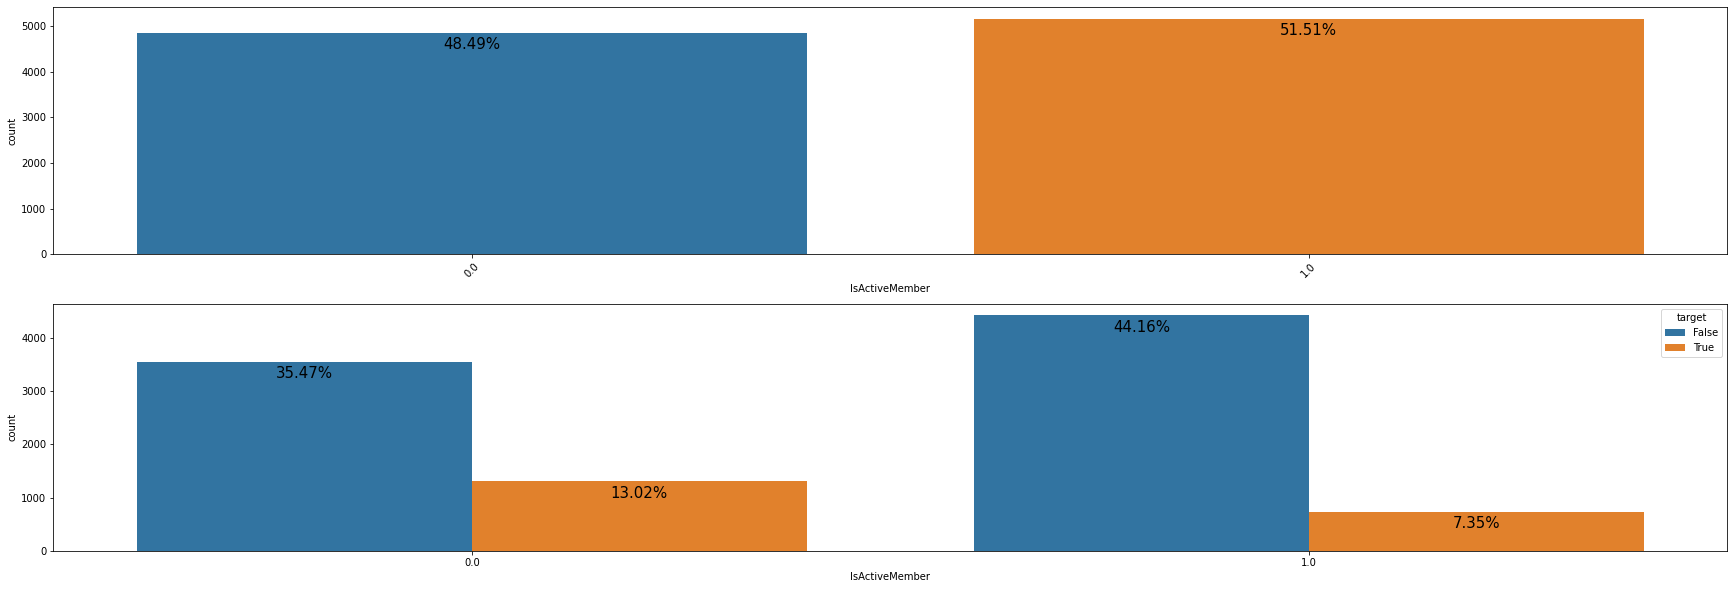

In [28]:
# Is active member 
plot_categories(clients_clean, column ='IsActiveMember', target='target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


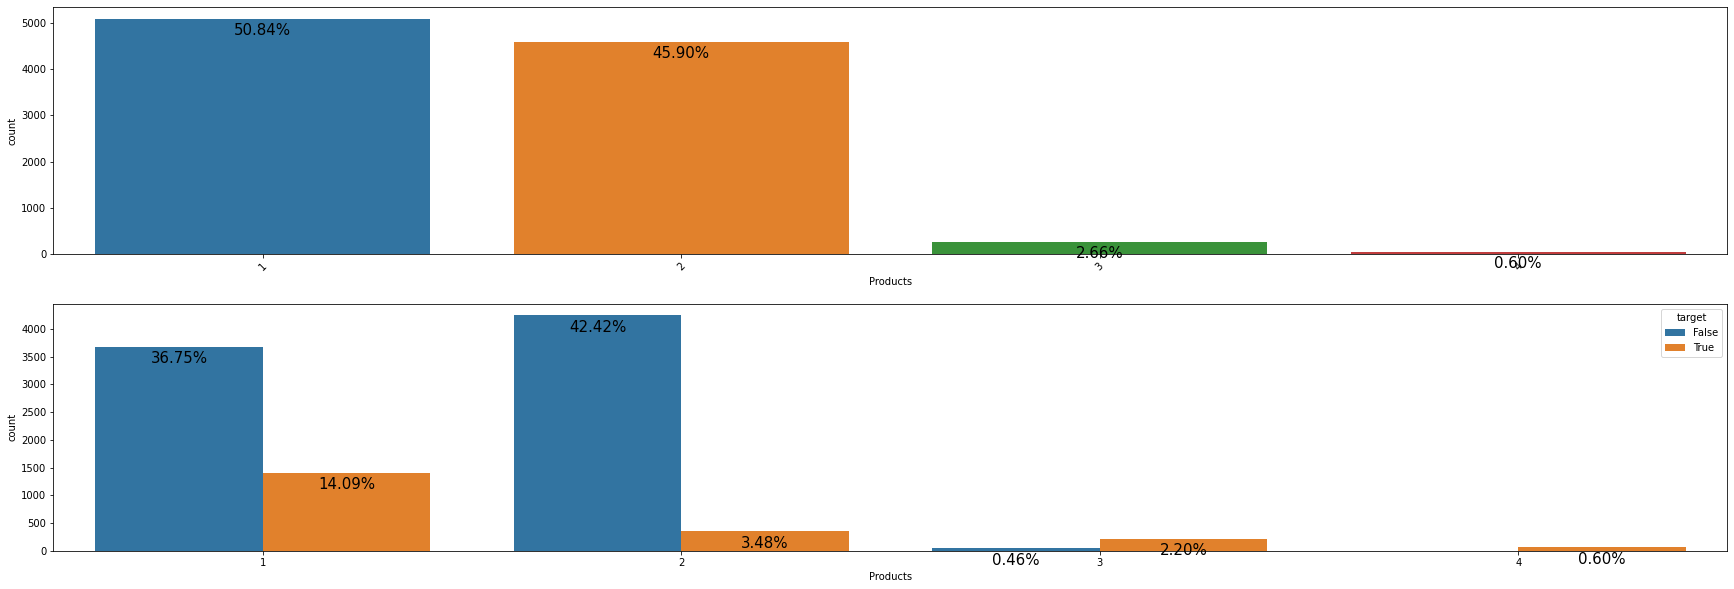

In [29]:
# Number of prodcuts
plot_categories(clients_clean, column ='Products', target='target')

## **Dummy variables Creation**

- Dummies for Estimated salary ranges
- Dummies for balance account
- Dummies for age
- dummies for Score
- dummy for product

In [30]:
# Drop all useless variables

clients_clean = clients_clean.loc[:,['CustomerId', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember','EstimatedSalary', 'age', 'target', 'Products', 'account_balance', 'Score']]

# Products 
clients_clean['only_one_Product'] = np.where(clients_clean['Products'] == 1, 1, 0)
clients_clean['more_than_one_product'] = np.where(clients_clean['Products'] > 1, 1, 0)
clients_clean.drop('Products', inplace = True, axis = 1)

# CustomerId
clients_clean.set_index('CustomerId',inplace=True)

# Gender
clients_clean['Gender'] = np.where(clients_clean['Gender'] == 'Female', 1, 0)

# Geography
clients_clean = OneHotEncoderFunction(clients_clean,'Geography')

# Estimated Salary
clients_clean['EstimatedSalary'] = pd.cut(clients_clean['EstimatedSalary'],10)
clients_clean = OneHotEncoderFunction(clients_clean,'EstimatedSalary')

# Account Balance 
clients_clean['account_balance'] = pd.cut(clients_clean['account_balance'],5)
clients_clean = OneHotEncoderFunction(clients_clean,'account_balance')

# Score
clients_clean['Score'] = pd.cut(clients_clean['Score'],5)
clients_clean = OneHotEncoderFunction(clients_clean,'Score')

# Age
clients_clean['age'] = pd.cut(clients_clean['age'],5)
clients_clean = OneHotEncoderFunction(clients_clean,'age')

display(clients_clean)




,Gender,HasCrCard,IsActiveMember,target,only_one_Product,more_than_one_product,Geography_France,Geography_Germany,Geography_Spain,"EstimatedSalary_(-188.401, 20009.67]","EstimatedSalary_(20009.67, 40007.76]","EstimatedSalary_(40007.76, 60005.85]","EstimatedSalary_(60005.85, 80003.94]","EstimatedSalary_(80003.94, 100002.03]","EstimatedSalary_(100002.03, 120000.12]","EstimatedSalary_(120000.12, 139998.21]","EstimatedSalary_(139998.21, 159996.3]","EstimatedSalary_(159996.3, 179994.39]","EstimatedSalary_(179994.39, 199992.48]","account_balance_(-250.898, 50179.618]","account_balance_(50179.618, 100359.236]","account_balance_(100359.236, 150538.854]","account_balance_(150538.854, 200718.472]","account_balance_(200718.472, 250898.09]","Score_(349.5, 450.0]","Score_(450.0, 550.0]","Score_(550.0, 650.0]","Score_(650.0, 750.0]","Score_(750.0, 850.0]","age_(17.926, 32.8]","age_(32.8, 47.6]","age_(47.6, 62.4]","age_(62.4, 77.2]","age_(77.2, 92.0]"
CustomerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15610711,1,0.0,0.0,False,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
15764170,0,1.0,0.0,True,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
15594720,1,1.0,1.0,False,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
15706552,0,0.0,1.0,False,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
15785358,0,1.0,1.0,True,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15689152,0,0.0,0.0,False,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
15787204,1,0.0,0.0,False,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
15606887,1,1.0,0.0,True,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0


## **Modelizacion**

In this section the churn probability modelling will be done.

## **SMOTE** 

Stands for Synthetic Minority Over-sampling Technique it consist in an oversample procedure for the minority class. Basically, it creates synthetic observations using the K-nearest neighbour algorythm. It chooses a random observation of the minority class and a random nearest neighbor to create a new observation between them. So the result will be new synthetic data rich in information, it helps to build up the algorythm perfomance.

In [31]:
# SMOTE technique for undersampled data

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

X_data = clients_clean.loc[:, clients_clean.columns != 'target']
Y_data = clients_clean.loc[:, clients_clean.columns == 'target']
X_res, y_res = sm.fit_resample(X_data, Y_data)

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size = 0.2)

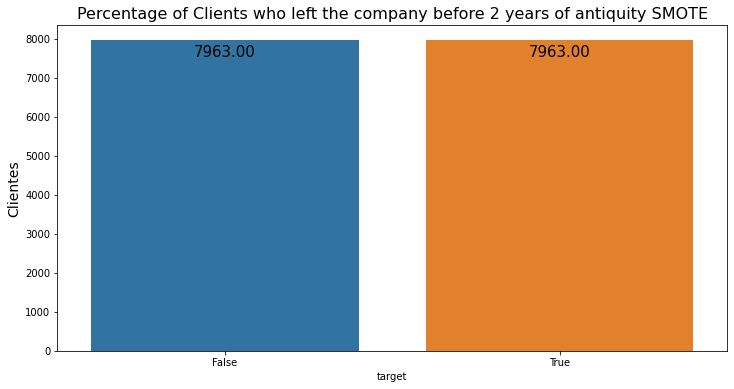

In [32]:
plt.figure(figsize=(12,6))

p3 = sns.countplot(data=y_res, x = 'target')

for p in p3.patches:
  p3.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Clientes", size = 14)
plt.title('Percentage of Clients who left the company before 2 years of antiquity SMOTE', size=16)

plt.show()


## **Baseline Model Logistic Regression**

In [33]:
# Logistic regression

baseline = linear_model.LogisticRegression()
baseline.fit(X_train, y_train)
predicted_labels = baseline.predict(X_test)

acc_log_reg = accuracy_score(y_test,predicted_labels)
f1s_logreg = f1_score(y_test,predicted_labels, average = 'macro')

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'macro'))
print('ROC AUC Score: ', roc_auc_score(y_test,predicted_labels))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score:  0.8509102322661645
F1 Score:  0.8503724745071615
ROC AUC Score:  0.8504776392326246


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## **Support Vector Classifier**

In [34]:
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier


lsvc =SVC(random_state=0, kernel = 'rbf')
lsvc.fit(X_train, y_train)
predicted_labels = lsvc.predict(X_test)

acc_svc = accuracy_score(y_test,predicted_labels)
f1_svc = f1_score(y_test,predicted_labels, average = 'macro')

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'macro'))
print('ROC AUC Score: ', roc_auc_score(y_test,predicted_labels))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score:  0.879472693032015
F1 Score:  0.8788846438957633
ROC AUC Score:  0.8789625928086132


## **Random Forest Classifier**

In [35]:
# Probamos un Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=5,random_state=27,
                       verbose=1,n_estimators = 1000,max_depth=20)

clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

acc_rf = accuracy_score(y_test,predicted_labels)
f1_rf = f1_score(y_test,predicted_labels, average = 'macro')

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))
print('ROC AUC Score: ', roc_auc_score(y_test,predicted_labels))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    7.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    

Accuracy Score:  0.8562460765850597
F1 Score Macro:  0.8562297033136803
ROC AUC Score:  0.856390198149345


[Text(0, 0, 'Gender'),
 Text(0, 0, 'HasCrCard'),
 Text(0, 0, 'IsActiveMember'),
 Text(0, 0, 'only_one_Product'),
 Text(0, 0, 'more_than_one_product'),
 Text(0, 0, 'Geography_France'),
 Text(0, 0, 'Geography_Germany'),
 Text(0, 0, 'Geography_Spain'),
 Text(0, 0, 'EstimatedSalary_(-188.401, 20009.67]'),
 Text(0, 0, 'EstimatedSalary_(20009.67, 40007.76]'),
 Text(0, 0, 'EstimatedSalary_(40007.76, 60005.85]'),
 Text(0, 0, 'EstimatedSalary_(60005.85, 80003.94]'),
 Text(0, 0, 'EstimatedSalary_(80003.94, 100002.03]'),
 Text(0, 0, 'EstimatedSalary_(100002.03, 120000.12]'),
 Text(0, 0, 'EstimatedSalary_(120000.12, 139998.21]'),
 Text(0, 0, 'EstimatedSalary_(139998.21, 159996.3]'),
 Text(0, 0, 'EstimatedSalary_(159996.3, 179994.39]'),
 Text(0, 0, 'EstimatedSalary_(179994.39, 199992.48]'),
 Text(0, 0, 'account_balance_(-250.898, 50179.618]'),
 Text(0, 0, 'account_balance_(50179.618, 100359.236]'),
 Text(0, 0, 'account_balance_(100359.236, 150538.854]'),
 Text(0, 0, 'account_balance_(150538.854, 20

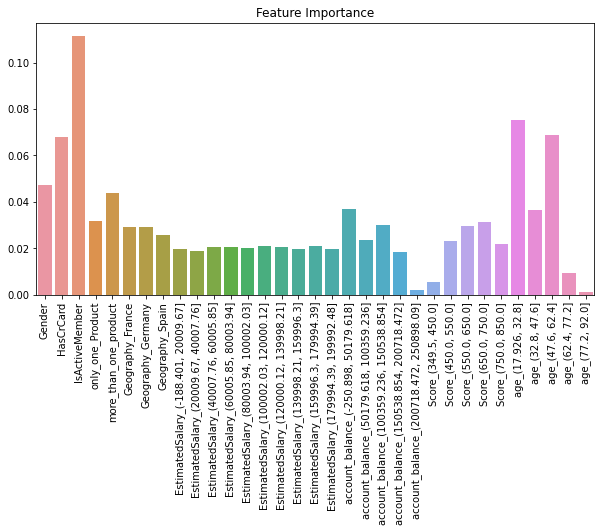

In [36]:
features = clients_clean.loc[:, clients_clean.columns != 'target'].columns
plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf.feature_importances_)
plot.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')

## **XGBoost**

I performed a XGBoost model, with a SMOTE methodology to solve for inbalanced data set. We perform a hyperparameter tunning with a Randomized search approach.

For metrics we use the accuracy and F1 scores.

XGBoost outperforms significally both SVM and Random Forest approaches.

In [37]:
# En este apartado pobamos un modelo XGBoost 
  
## Modelo Base
xg = xgb.XGBClassifier()
xg.fit(X_train.values,y_train.values)
predicted_labels = xg.predict(X_test.values)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'macro'))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'micro'))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score:  0.8305084745762712
F1 Score:  0.8304761416778176
F1 Score:  0.8305084745762712


In [38]:
## Hyperparameter Tunning 

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

clf = RandomizedSearchCV(estimator = xg,
                         param_distributions=params,
                         scoring='f1_macro',
                         n_iter=25,
                         verbose=1)
clf.fit(X_train.values,y_train.values)

predicted_labels = clf.best_estimator_.predict(X_test.values)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score Micro: ', f1_score(y_test,predicted_labels, average = 'micro'))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Accuracy Score:  0.8788449466415568
F1 Score Micro:  0.8788449466415568
F1 Score Macro:  0.8786302483854158


In [39]:
# Results XGBoot predictions

acc_xgb = accuracy_score(y_test,predicted_labels)
f1_xgb = f1_score(y_test,predicted_labels, average = 'macro')
roc_auc_xgb = roc_auc_score(y_test,predicted_labels,) 

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('ROC AUC Score: ', roc_auc_score(y_test,predicted_labels))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))

Accuracy Score:  0.8788449466415568
ROC AUC Score:  0.8785602251052225
F1 Score Macro:  0.8786302483854158


[Text(0, 0, 'Gender'),
 Text(0, 0, 'HasCrCard'),
 Text(0, 0, 'IsActiveMember'),
 Text(0, 0, 'only_one_Product'),
 Text(0, 0, 'more_than_one_product'),
 Text(0, 0, 'Geography_France'),
 Text(0, 0, 'Geography_Germany'),
 Text(0, 0, 'Geography_Spain'),
 Text(0, 0, 'EstimatedSalary_(-188.401, 20009.67]'),
 Text(0, 0, 'EstimatedSalary_(20009.67, 40007.76]'),
 Text(0, 0, 'EstimatedSalary_(40007.76, 60005.85]'),
 Text(0, 0, 'EstimatedSalary_(60005.85, 80003.94]'),
 Text(0, 0, 'EstimatedSalary_(80003.94, 100002.03]'),
 Text(0, 0, 'EstimatedSalary_(100002.03, 120000.12]'),
 Text(0, 0, 'EstimatedSalary_(120000.12, 139998.21]'),
 Text(0, 0, 'EstimatedSalary_(139998.21, 159996.3]'),
 Text(0, 0, 'EstimatedSalary_(159996.3, 179994.39]'),
 Text(0, 0, 'EstimatedSalary_(179994.39, 199992.48]'),
 Text(0, 0, 'account_balance_(-250.898, 50179.618]'),
 Text(0, 0, 'account_balance_(50179.618, 100359.236]'),
 Text(0, 0, 'account_balance_(100359.236, 150538.854]'),
 Text(0, 0, 'account_balance_(150538.854, 20

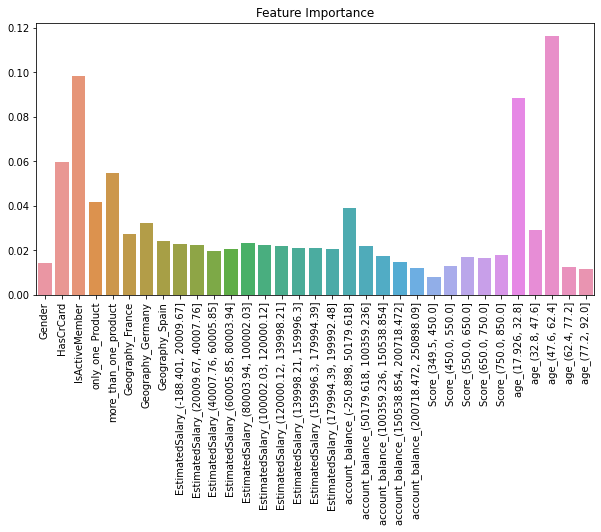

In [40]:
# XG Boost Features Importance

features = clients_clean.loc[:, clients_clean.columns != 'target'].columns
plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf.best_estimator_.feature_importances_)
plot.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')